In [1]:
import pandas as pd
import numpy as np
import os 
#import seaborn as sns
#import matplotlib as mpl
import matplotlib.pyplot as plt


In [94]:
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

sns.set_theme()

import cpi
from datetime import date

In [403]:
def computeCPI():
    baseYear = date(2018,12,31)
    startYear = date(2000,1,1)
    endYear = date(2019,12,31)
    startStop = np.arange(startYear, endYear, dtype='datetime64[M]')
    avgCPI = cpi.get(startYear, items="Housing")/cpi.get(baseYear, items="Housing")
    timeDiff = baseYear-startYear
    timeDiff = timeDiff.days
    avgCPI = avgCPI/timeDiff

    cpiFrac = []
    for dt in startStop:
        refYear = dt.tolist()
        if(refYear > baseYear):
            #refYear = baseYear
            dt = refYear - baseYear
            dt = dt.days
            cpiFrac.append([refYear, 1 + avgCPI*dt])
        else:
            cpiFrac.append([refYear, cpi.get(refYear, items="Housing")/cpi.get(baseYear, items="Housing")])
    
    df = pd.DataFrame(cpiFrac,columns=['datetime','CPI'])
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

In [404]:
cpiFrac = computeCPI()
#interpolate time by month
def getCPI(cpi, x, colName):
    if(x['datetime'] in cpi['datetime'].values):
        y= x[colName]/cpi[cpi['datetime']==x['datetime']]['CPI'].values[0]
        #print(y)
        return y
    else:
        return x[colName]

In [405]:
def seasonalityCorr(df, colName, FipsCol = "Fips"):
    fips_rng = np.unique(df[FipsCol])
    newCol = colName + "_seasonality"
    x = pd.DataFrame(data = [], columns=[FipsCol, "datetime", newCol])
    for fips in fips_rng:
        df_fips = df[df[FipsCol]==fips].copy()
        df_fips.set_index(df_fips['datetime'], inplace=True)
        res = sm.tsa.seasonal_decompose(df_fips[colName])
        df_fips[newCol] = df_fips[colName] - res.seasonal
        y = df_fips[[newCol, 'datetime']].copy()
        y.reset_index(inplace=True, drop=True)
        y[FipsCol] = fips
        x = x.append(y,ignore_index = True)
    return x

In [406]:
#data should not go out of range
startYear = date(2000,1,1)
endYear = date(2019,12,31)

df_hpi_q = pd.read_csv('../Regression Model/hpi.csv')

In [407]:
df_fips = pd.read_csv('data-cbsa-fips.csv', delimiter=';')
df_fips_state = df_fips[['State Name','FIPS State Code']].copy()
df_fips_state.drop_duplicates(inplace=True)
df_fips_state.rename(columns={'State Name':'StateName', 'FIPS State Code':'Fips'}, inplace=True)
df_fips_state.dropna(inplace=True)
df_fips_state['Fips'] = df_fips_state['Fips'].astype(int)

In [408]:
df_hpi_q = df_hpi_q.merge(df_fips_state, on= 'Fips')
df_hpi_q['datetime'] = df_hpi_q['Year'].astype(str) +"-"+ df_hpi_q['Month'].astype(str)
df_hpi_q['datetime'] = pd.to_datetime(df_hpi_q['datetime'])
df_hpi_q = df_hpi_q[df_hpi_q['datetime'] <= pd.to_datetime(endYear)]

<AxesSubplot:xlabel='datetime'>

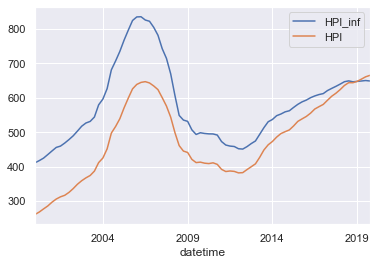

In [409]:
df_hpi_q['HPI_inf'] = df_hpi_q.apply(lambda x: getCPI(cpiFrac, x, 'HPI'), axis=1)
df_hpi_q.drop(['Year', 'Month', 'StateName'], axis=1, inplace=True)
df_hpi_q[df_hpi_q['StateName']=='California'].plot(y = ['HPI_inf', 'HPI'], x = 'datetime')

<AxesSubplot:xlabel='datetime'>

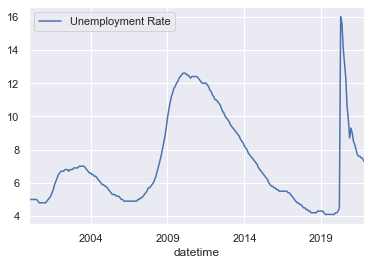

In [410]:
df_employment = pd.read_csv('../Regression Model/unemployment.csv')
df_employment = df_employment[df_employment["Year"]>=2000].copy()
df_employment['datetime'] = df_employment['Year'].astype(str) +"-"+ df_employment['Month'].astype(str)
df_employment['datetime'] = pd.to_datetime(df_employment['datetime'])
df_employment['Unemployment Rate'] = df_employment['Unemployment Rate'].astype(float)
df_employment[df_employment['Fips']==6].plot(y = 'Unemployment Rate', x = 'datetime')
df_employment.drop(columns=['Month', 'Year'], inplace=True)

In [411]:
df_hpa = pd.read_csv('../Regression Model/HPA_formatted_05-19.csv')
df_hpa['datetime'] = df_hpa['Year'].astype(str) +"-"+ df_hpa['Month'].astype(str)
df_hpa['datetime'] = pd.to_datetime(df_hpa['datetime'])
df_hpa.drop(['region','sub_region'], axis=1, inplace=True)
df_hpa.head()

,StateName,Fips,Year,Month,total_number_hpa,datetime
0,Connecticut,9,2005,1,651,2005-01-01
1,Maine,23,2005,1,400,2005-01-01
2,Massachusetts,25,2005,1,1544,2005-01-01
3,New Hampshire,33,2005,1,497,2005-01-01
4,Rhode Island,44,2005,1,128,2005-01-01


In [412]:
x = seasonalityCorr(df_hpa, 'total_number_hpa')
df_hpa = df_hpa.merge(x, on=['datetime', 'Fips'])
df_hpa.head()

,StateName,Fips,Year,Month,total_number_hpa,datetime,total_number_hpa_seasonality
0,Connecticut,9,2005,1,651,2005-01-01,792.745040
1,Maine,23,2005,1,400,2005-01-01,535.178323
2,Massachusetts,25,2005,1,1544,2005-01-01,1738.322917
3,New Hampshire,33,2005,1,497,2005-01-01,568.736607
4,Rhode Island,44,2005,1,128,2005-01-01,154.152778


In [413]:
df_hpa.drop(['Year', 'Month', 'StateName'], axis=1, inplace=True)
df_hpa.head()

,Fips,total_number_hpa,datetime,total_number_hpa_seasonality
0,9,651,2005-01-01,792.745040
1,23,400,2005-01-01,535.178323
2,25,1544,2005-01-01,1738.322917
3,33,497,2005-01-01,568.736607
4,44,128,2005-01-01,154.152778


<AxesSubplot:xlabel='datetime'>

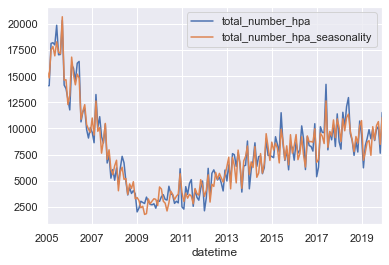

In [91]:
df_hpa[df_hpa['StateName'] == 'California'].plot(y = ['total_number_hpa', 'total_number_hpa_seasonality'], x = 'datetime')
#df_hpa2[df_hpa2['StateName'] == 'California'].plot(y = 'total_number_hpa_seasonality', x = 'datetime')

In [92]:
df_hpa.to_csv('../Regression Model/HPA_corrected.csv', index = False)

In [401]:
df_intRate = pd.read_csv('../Regression Model/data-interest-rate.csv')
df_intRate['DATE'] = pd.to_datetime(df_intRate['DATE'])
df_intRate = df_intRate[df_intRate['DATE']>=pd.to_datetime(startYear)]
df_intRate.rename(columns={'DATE':'datetime', 'INTDSRUSM193N':'IntRate'}, inplace=True)
df_intRate.head()

,datetime,IntRate
600,2000-01-01,5.00
601,2000-02-01,5.24
602,2000-03-01,5.34
603,2000-04-01,5.50
604,2000-05-01,5.71


In [476]:
df_Pop = pd.read_csv('../Regression Model/data-population-merged.csv')
df_Pop.drop('Area', axis=1, inplace=True)

In [477]:
colName =  df_Pop.columns[1:]
newCols = {col:col + "-12-01" for col in colName}
df_Pop.rename(columns=newCols, inplace=True)

In [484]:
pd.to_datetime('2012-12-01').month

12

In [501]:
def getPopulation(df, Fips):
    df_Pop_fips = df[df['Fips']==Fips].copy()
    x = df_Pop_fips.columns.difference(['Fips'])
    df_Pop_fips = pd.Series(df_Pop_fips[x].values[0], index = pd.to_datetime(x))
    #df_Pop_fips.index = pd.to_datetime(df_Pop_fips.index)
    df_Pop_fips = df_Pop_fips.resample('MS')
    #https://codingandfun.com/resampling-time-series-with-pandas-from-daily-to-monthly-nasdaq-prices/
    z = df_Pop_fips.interpolate(method='time')
    #z.plot(y = 'Population')
    #return z['Population'].values[-1]
    return z
#z.values

In [504]:
fips_rng = np.unique(df_Pop['Fips'])
df_popState = pd.DataFrame(columns=['datetime', 'Fips', 'Population'])
for fips in fips_rng:
    x = getPopulation(df_Pop, fips)
    y = pd.DataFrame(data = x.values, index = x.index, columns = ['Population'])
    y['datetime'] = y.index
    y['Fips'] = fips
    y.reset_index(drop=True, inplace=True)
    df_popState = df_popState.append(y)

In [436]:
df_conf = pd.read_csv('../Regression Model/ConsumerConfidence.csv')
df_conf['datetime'] = pd.to_datetime(df_conf['TIME'])
df_conf = df_conf[df_conf['LOCATION'].str.contains('USA')]
df_conf.drop(['LOCATION', 'INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Flag Codes', 'TIME'], axis=1, inplace=True)
df_conf.rename(columns = {'Value':'CCI'}, inplace=True)
df_conf.reset_index(drop=True, inplace=True)
df_conf.head()

,CCI,datetime
0,102.9801,2000-01-01
1,103.0381,2000-02-01
2,102.9493,2000-03-01
3,102.9290,2000-04-01
4,102.9013,2000-05-01


In [368]:
df_GSVI = pd.read_csv('../Regression Model/merged_GSVI_clean.csv')
df_GSVI.head()

,geoName,Apartment,year,Construction,Home,Investment,Mortgage,Realtor,Real Estate,Real Estate Agent,Real Estate Listings,Rent,zillow
0,Alabama,56,2005-01-31,0,15,0,0,9,72,39,0,7,0
1,Alaska,0,2005-01-31,0,0,0,0,55,59,0,0,21,0
2,Arizona,54,2005-01-31,17,42,12,0,37,60,17,17,64,0
3,Arkansas,23,2005-01-31,0,19,0,0,77,52,0,40,29,0
4,California,46,2005-01-31,11,18,23,10,24,60,11,24,57,0


In [369]:
df_GSVI.rename(columns={'geoName':'StateName', 'year':'datetime'}, inplace=True)
df_GSVI['datetime'] = pd.to_datetime(df_GSVI['datetime'])
df_GSVI = df_GSVI.merge(df_fips_state,on='StateName')

In [370]:
df_GSVI.head()

,StateName,Apartment,datetime,Construction,Home,Investment,Mortgage,Realtor,Real Estate,Real Estate Agent,Real Estate Listings,Rent,zillow,Fips
0,Alabama,56,2005-01-31,0,15,0,0,9,72,39,0,7,0,1
1,Alabama,28,2005-02-28,0,38,0,14,50,45,0,0,56,0,1
2,Alabama,28,2005-03-31,20,33,0,40,0,50,13,25,54,0,1
3,Alabama,61,2005-04-30,0,39,0,0,10,40,0,41,30,0,1
4,Alabama,21,2005-05-31,0,41,0,25,61,40,0,0,42,0,1


In [422]:
colToIgnore = ['StateName', 'datetime', 'Fips']
colToProcess = [col for col in df_GSVI.columns if col not in colToIgnore]

df_GSVI2 = seasonalityCorr(df_GSVI, colToProcess[0])
for col in colToProcess[1:]:
    df_GSVI2 = df_GSVI2.merge(seasonalityCorr(df_GSVI, col), on=['datetime', 'Fips'])

gsviCols = [col for col in df_GSVI2.columns if col not in colToIgnore]
#set the first date
df_GSVI2['datetime'] = df_GSVI2['datetime']- pd.offsets.MonthEnd(1) + pd.offsets.Day(1)
df_GSVI2.head()

,Fips,datetime,Apartment_seasonality,Construction_seasonality,Home_seasonality,Investment_seasonality,Mortgage_seasonality,Realtor_seasonality,Real Estate_seasonality,Real Estate Agent_seasonality,Real Estate Listings_seasonality,Rent_seasonality,zillow_seasonality
0,1,2005-01-31,53.041154,9.984094,15.430142,-1.815261,-7.417460,7.362070,70.980291,35.431845,-5.257044,8.120089,-2.459210
1,1,2005-02-28,29.860599,-4.988128,43.302364,5.201405,14.796429,45.734292,44.863624,2.190179,-1.173710,54.678423,-1.284210
2,1,2005-03-31,28.596710,19.925761,32.974587,-6.468039,38.501984,-3.029597,51.027513,11.273512,12.254067,49.508978,0.996346
3,1,2005-04-30,63.474487,-8.888128,42.249587,1.184739,-1.720238,8.078737,43.427513,2.820734,43.934623,26.381200,0.543568
4,1,2005-05-31,19.441154,-1.749239,42.616253,-4.318039,31.713095,61.450959,39.410847,1.204067,-3.943155,37.414534,-1.331432


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

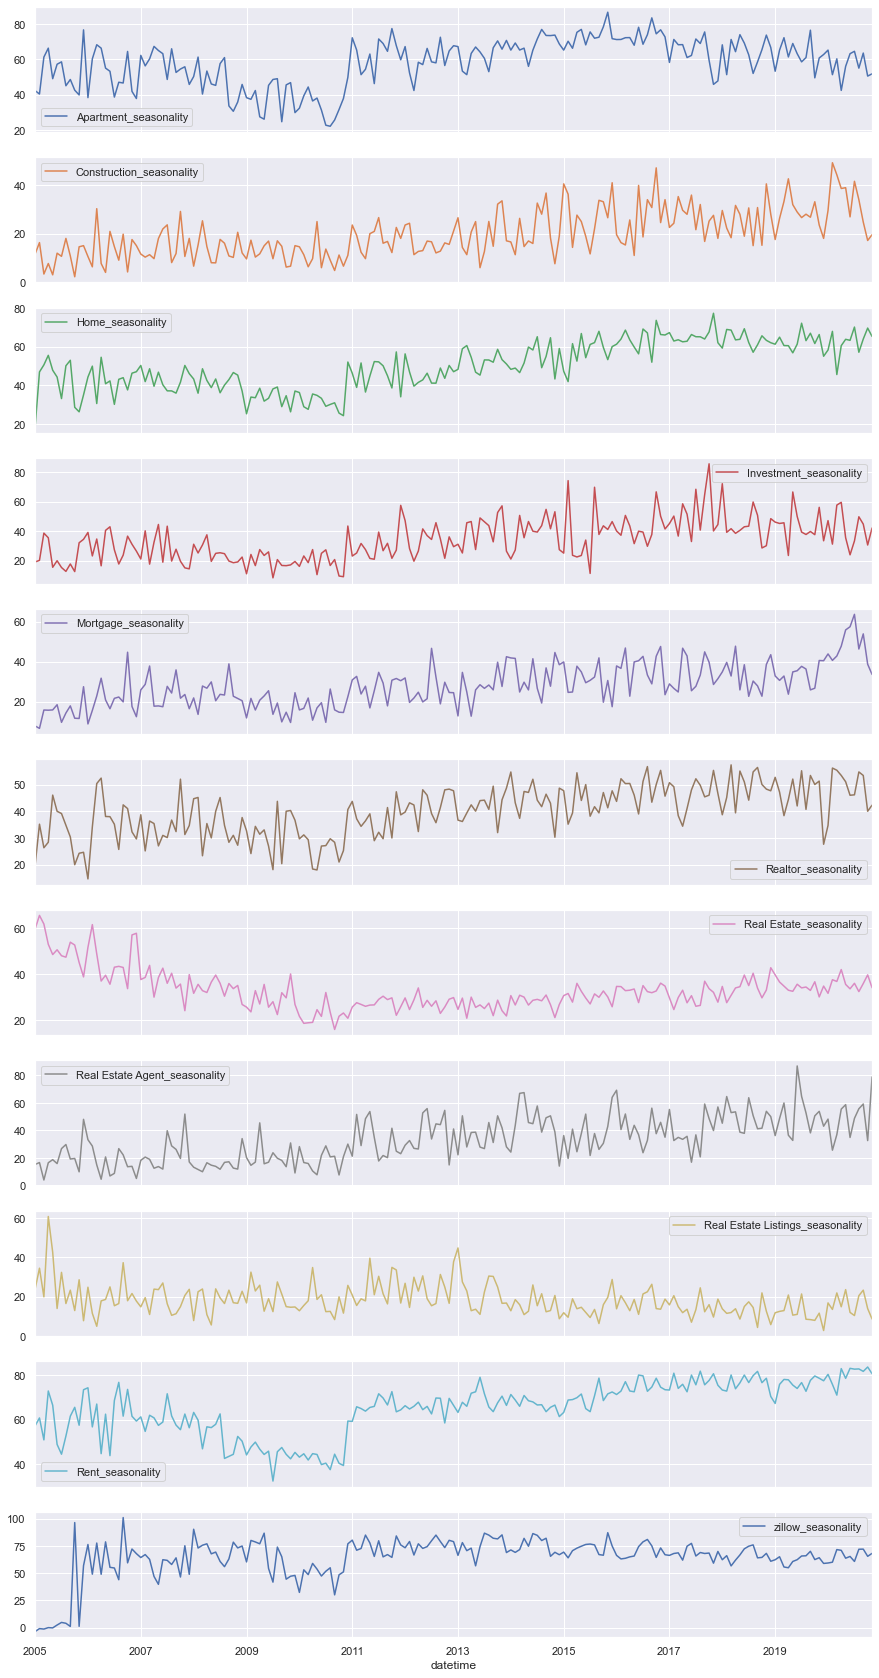

In [423]:
df_GSVI2[df_GSVI2['Fips']==6].plot(y = gsviCols, x = 'datetime', subplots = True, legend = True, figsize = (15,30))

In [ ]:
#data
#df_conf : ['CCI','datetime']/month
#df_employment : [Fips	Unemployment Rate	datetime]/month
#df_GSVI2: [Fips	datetime gsviCols] /month
#df_hpi_q: [HPI	Fips	datetime	HPI_inf] /quater
#df_hpa: [Fips	total_number_hpa	datetime	total_number_hpa_seasonality]/month
#df_intRate: [datetime	IntRate]/month
#df_popState: ['datetime', 'Fips', 'Population']/month


In [522]:
#merge all data
df_int_cci = df_intRate.merge(df_conf, on=['datetime'])
df_int_cci.to_csv('../Regression Model/interest_rate_cci.csv', index = False)


In [519]:
df_all_noHPI  = df_employment.merge(df_hpa, on=['datetime', 'Fips'])
#df_all_noHPI['Fips'] = df_all_noHPI['Fips'].astype(int)
#df_GSVI2['Fips'] = df_GSVI2['Fips'].astype(int)
#df_popState['Fips'] = df_popState['Fips'].astype(int)
df_all_noHPI = df_all_noHPI.merge(df_popState, on=['Fips', 'datetime'])
df_all_noHPI = df_all_noHPI.merge(df_GSVI2, on=['datetime', 'Fips'])

In [521]:
df_all_noHPI.to_csv('../Regression Model/allData_noHPI.csv', index=False)

In [523]:
df_hpi_q.to_csv('../Regression Model/hpaFinal.csv', index=False)

In [524]:
df_all_noHPI.head(2)

,Fips,Unemployment Rate,datetime,total_number_hpa,total_number_hpa_seasonality,Population,Apartment_seasonality,Construction_seasonality,Home_seasonality,Investment_seasonality,Mortgage_seasonality,Realtor_seasonality,Real Estate_seasonality,Real Estate Agent_seasonality,Real Estate Listings_seasonality,Rent_seasonality,zillow_seasonality
0,5,5.4,2005-01-01,1402,1471.097718,2.752354e+06,20.449190,-0.150562,24.455324,-5.968634,-3.073843,72.577232,51.557523,4.530076,42.191882,32.163806,-1.144378
1,5,5.3,2005-02-01,1340,1362.776290,2.755022e+06,5.785301,73.813327,23.999769,-4.168634,5.042824,49.238343,45.085301,52.002298,51.583548,60.374917,-3.072156


In [528]:
#df_all_noHPI.groupby(pd.Grouper(key="datetime", freq="Q", origin = '2000-01-01')).sum()

In [525]:
df_hpi_q.head()

,HPI,Fips,datetime,HPI_inf
0,208.32,1,2000-01-01,327.991055
1,210.09,1,2000-04-01,327.034678
2,211.74,1,2000-07-01,324.386673
3,214.42,1,2000-10-01,326.387951
4,220.69,1,2001-01-01,331.301197


In [554]:
df_all_noHPI_Q = df_all_noHPI.groupby(['Fips', pd.Grouper(key="datetime", freq="Q", origin = '2000-01-01')]).sum()
#, as_index = False

In [555]:
df_all_noHPI_Q['key'] = list(df_all_noHPI_Q.index)
df_all_noHPI_Q['Fips_new'] = df_all_noHPI_Q['key'].apply(lambda x: x[0])
df_all_noHPI_Q['date_new'] = df_all_noHPI_Q['key'].apply(lambda x: x[1])
df_all_noHPI_Q.drop(['key'], axis=1, inplace=True)
df_all_noHPI_Q.reset_index(drop=True, inplace=True)
df_all_noHPI_Q.rename(columns={'Fips_new':'Fips', 'date_new':'datetime'}, inplace=True)
df_all_noHPI_Q['datetime'] = df_all_noHPI_Q['datetime'] + pd.offsets.Day(1)
df_all_noHPI_Q.head()

,Unemployment Rate,total_number_hpa,total_number_hpa_seasonality,Population,Apartment_seasonality,Construction_seasonality,Home_seasonality,Investment_seasonality,Mortgage_seasonality,Realtor_seasonality,Real Estate_seasonality,Real Estate Agent_seasonality,Real Estate Listings_seasonality,Rent_seasonality,zillow_seasonality,Fips,datetime
0,14.6,8017,8083.926339,1.361178e+07,111.498462,24.921726,91.707093,-3.081895,45.880952,50.066766,166.871429,48.895536,5.823313,112.307490,-2.747073,1,2005-04-01
1,13.4,8196,7877.259673,1.364079e+07,117.001835,-15.623512,146.984276,-4.170982,82.965476,82.446925,129.069048,1.235615,66.410615,95.183085,-3.728224,1,2005-07-01
2,12.9,7149,7096.622768,1.367023e+07,99.626240,91.888393,144.890427,54.040327,73.414286,109.030655,146.243651,61.162202,51.895536,93.088046,5.311260,1,2005-10-01
3,12.6,7309,7613.191220,1.369967e+07,169.873462,49.813393,160.418204,5.212550,120.739286,147.455655,119.815873,-1.293353,26.870536,177.421379,1.164038,1,2006-01-01
4,12.3,7407,7473.926339,1.373908e+07,192.498462,146.921726,168.707093,81.918105,62.880952,85.066766,165.871429,122.895536,-4.176687,145.307490,49.252927,1,2006-04-01


In [556]:
df_all = df_all_noHPI_Q.merge(df_hpi_q, on =['Fips', 'datetime'])

In [561]:
df_all =  df_all.merge(df_int_cci, on=['datetime'])

In [563]:
df_all.to_csv('../Regression Model/allData.csv', index=False)

<AxesSubplot:xlabel='datetime'>

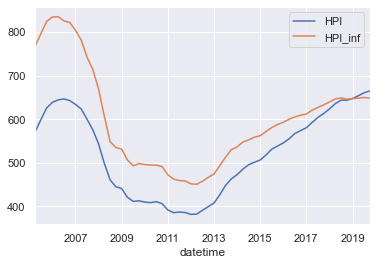

In [565]:
df_all[df_all['Fips']==6].plot(x = 'datetime', y = ['HPI', 'HPI_inf'])

In [564]:
df_all.head()

,Unemployment Rate,total_number_hpa,total_number_hpa_seasonality,Population,Apartment_seasonality,Construction_seasonality,Home_seasonality,Investment_seasonality,Mortgage_seasonality,Realtor_seasonality,...,Real Estate Agent_seasonality,Real Estate Listings_seasonality,Rent_seasonality,zillow_seasonality,Fips,datetime,HPI,HPI_inf,IntRate,CCI
0,14.6,8017,8083.926339,1.361178e+07,111.498462,24.921726,91.707093,-3.081895,45.880952,50.066766,...,48.895536,5.823313,112.307490,-2.747073,1,2005-04-01,262.46,352.862889,3.75,100.4529
1,21.0,515,614.816964,1.981698e+06,69.597073,114.008829,105.119444,86.733482,-10.686954,144.174653,...,-4.100843,65.446528,128.374554,-9.886905,2,2005-04-01,247.86,333.234000,3.75,100.4529
2,13.9,20867,21059.273810,1.705080e+07,184.378125,63.225198,171.249603,63.468849,15.534623,141.135516,...,46.779812,27.424653,214.524504,-8.183631,4,2005-04-01,341.95,459.732778,3.75,100.4529
3,16.0,4267,4301.733631,8.264807e+06,58.330903,81.451091,101.379861,-12.230903,2.700694,126.148363,...,63.793006,135.425645,192.466419,-3.391468,5,2005-04-01,232.55,312.650556,3.75,100.4529
4,17.1,46309,47793.580357,1.068508e+08,143.940575,31.182093,115.881052,77.978224,30.316121,81.244296,...,35.770387,78.198859,168.877381,-6.064087,6,2005-04-01,570.63,767.180333,3.75,100.4529


In [566]:
df_fips_state

,StateName,Fips
0,Georgia,13
1,Alaska,2
5,South Carolina,45
6,Nebraska,31
7,Minnesota,27
8,Virginia,51
10,Washington,53
11,Idaho,16
12,Illinois,17
15,Kentucky,21
